In [2]:
# https://shorturl.at/nyzL4
# https://shorturl.at/FO479
import gymnasium as gym
import math
import random
import copy
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns; sns.set()

In [3]:
env = gym.make("BipedalWalker-v3") #Setting up an existing open AI gym environment
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

    plt.ion()
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU acceleration 

In [4]:
""" Represents a single transition in the environment. Used for experience replay. """
Experience = namedtuple('Experience',                                       
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory:
    """Fixed-size memory buffer to store Experience tuples."""
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Experience(*args))
    
    def sample(self, batch_size):
        """ Selects a random batch of transitions for training"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):
    """
    Deep Q-Network model
    """
    def __init__(self, state_size, action_size, seed):
        """
        Initialize parameters and construct DQN model
        
        @param state_size(int) : Dimensions of each state
        @param action_size(int): Dimensions of each action
        @param seed            : Random seed
        """
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,64)
        self.fc2 = nn.Linear(64, 48)
        self.fc3 = nn.Linear(48, 48)
        self.fc4_1 = nn.Linear(48, action_size)
        self.fc4_2 = nn.Linear(48, action_size)
        self.fc4_3 = nn.Linear(48, action_size)
        self.fc4_4 = nn.Linear(48, action_size)
        
    def forward(self, state):
        """
        Forward propagation of the network
        
        @param state: state
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred1 = self.fc4_1(x) # shape: (20,)
        pred2 = self.fc4_2(x)
        pred3 = self.fc4_3(x)
        pred4 = self.fc4_4(x)
        return pred1, pred2, pred3, pred4 

In [6]:
""" Hyperparameters (Maybe receive these as arguments? (parse_args))"""
MEMORY_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
EPSILON = 1.0
EPSILON_MIN = 0.05
EPS_DECAY = 1e-3
UPDATE_EVERY = 4

class Agent():
    """
    Agent that interacts and learns from the environment.
    Receives rewards from the environment, update DQN parameters, "memorize" experiences.
    """
    def __init__(self, state_space, action_space, disc_class, seed):
        """
        Initialize parameters and construct an Agent object
        
        @param state_size(int) : Dimensions of each state
        @param action_size(int): Dimensions of each action
        @param seed            : Random seed
        """
        self.state_space = state_space
        self.action_space = action_space
        self.disc_class = disc_class
        self.seed = random.seed(seed)
        
        # Initalize main and target DQN 
        self.main_model = DQN(state_space.shape[0], disc_class, seed).to(device)
        self.target_model = DQN(state_space.shape[0], disc_class, seed).to(device)
        self.target_model.load_state_dict(self.main_model.state_dict())
        self.target_model.eval()
        
        self.optimizer = optim.Adam(self.main_model.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayMemory(MEMORY_SIZE)
        
        # Initialize time step (for updating every UPDATE_EVERY step)
        self.t_step = 0
        self.eps_step = 0
        self.spacing = 0.1
        
    def step(self, state, action, reward, next_state):
        """
        Initialize parameters and construct an Agent object
        
        @param state     : Current state
        @param action    : action taken from the current state
        @param reward    : Reward given from the environment
        @param next_state: Next state according to the (state,action) pair
        """
        # save experience in replay memory
        self.memory.push(state, action, reward, next_state)
        
        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step+1)%UPDATE_EVERY
        if self.t_step == 0:
            
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(BATCH_SIZE)
                self.learn(experiences, GAMMA)
        
    def choose_action(self, state):
        """
        Return action for given state following the current policy
        
        @param state: Current state
        @param epsilon(float)  : epsilon for epsilon-greedy action selection
        """
        eps_threshold = EPSILON_MIN + (EPSILON - EPSILON_MIN) * math.exp(-1 * self.eps_step / EPS_DECAY)
        self.eps_step += 1
        # epsilon-greedy action selection
        if random.random() > eps_threshold:
            with torch.no_grad():
                pred1, pred2, pred3, pred4 = self.main_model(state)
                pred1 = np.argmax(pred1)
                pred2 = np.argmax(pred2)
                pred3 = np.argmax(pred3)
                pred4 = np.argmax(pred4)
                action = torch.tensor((pred1, pred2, pred3, pred4))
                # print("max:",action, action.shape)
                return action
        else:
            action = torch.randint(0, 19, (4,))
            # print("random:", action, action.shape)
            return action
        
    def disct2cont(self,action):
        return action * self.spacing - self.action_space.high
    
    def learn(self, experiences, gamma):
        """
        Update parameters using the given batch of expreience tuples
        
        @param experiences(Tuple): tuple of (s,a,s',r) tuples
        @param gamma(float): discount factor
        """
        batch = Experience(*zip(*experiences)) # This converts batch-array of Experiences
                                               # to Experience of batch-arrays.
        #batch.action --> (batch_size, tensor(4,))               ==> (64, tensor(4,))
        #batch.state --> (batch_size, tensor(1,state_size))      ==> (64, tensor(1,24))
        #batch.next_state --> (batch_size, tensor(1,state_size)) ==> (64, tensor(1,24))
        #batch.reward --> (batch_size, tensor(1))                ==> (64, tensor(1))
        action_batch = torch.cat(batch.action)         # tensor(256, )
        state_batch = torch.cat(batch.state)           # tensor(64, state_size)
        next_state_batch = torch.cat(batch.next_state) # tensor(64, state_size)
        reward_batch = torch.cat(batch.reward) # shape (64, )
        rewards = reward_batch.repeat(4,1) # shape: tensor(4,64)
        
        # print(batch.action)
        # print(action_batch)
        self.main_model.train() # Set local network as training mode
        self.target_model.eval() # Set target network as evaluation mode

        # Compute Q(s_t, a) - the model computes Q(s_t)
        q_evals = self.main_model(state_batch)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        q_next = self.target_model(next_state_batch) # shape: tensor (4,64,20)
        # q_next_max = torch.zeros(4,64)
        # for i in range(len(q_next_max)):
        #     q_next_max[i] = torch.amax(q_next[i],dim=1)
        q_eval = torch.zeros([4,64,20])
        q_target = torch.zeros([4,64,20])
        for heads in range(len(q_eval)):
            q_eval[heads]  = q_evals[heads] # shape: (4,64,20)
            for batch_index in range(BATCH_SIZE):
                q_target[heads][batch_index] = reward_batch[batch_index] + gamma * q_next[heads][batch_index]
        # q_target = reward_batch + torch.mul(gamma,q_next) # q_next.max
        # q_target = (q_next * gamma) + reward_batch # DQN update rule
        criterion = nn.SmoothL1Loss()
        loss = criterion(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        """ UPDATE TARGET NETWORK Don't update every step (compare) """ 
        self.soft_update(self.main_model, self.target_model, TAU)
    
    def soft_update(self, main_model, target_model, tau):
        """
        θ_target = τ*θ_local + (1 - τ)*θ_target
        
        @param local_model(nn model): weights will be copied from
        @param target_model(nn model): weights will be copied to
        @param tau(float): interpolation parameter
        """
        target_model_state_dict = target_model.state_dict()
        main_model_state_dict = main_model.state_dict()
        for key in main_model_state_dict: # what is the key?
            target_model_state_dict[key] = main_model_state_dict[key]*tau + target_model_state_dict[key]*(1-tau)
        target_model.load_state_dict(target_model_state_dict)

In [7]:
def plot_returns(returns, window=10):
    '''
    Returns (iterable): list of returns over time
    window: window for rolling mean to smooth plotted curve
    '''
    sns.lineplot(
        data=pd.DataFrame(returns).rolling(window=window).mean()[window-1::window]
    )

Episode 1


/Users/martinlee/miniconda3/envs/multi_pred/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'torch.Tensor'>
  logger.warn(


t 1599	Average Score -104.81
Episode 2
t 1599	Average Score -104.91
Episode 3
t 1599	Average Score -105.36
Episode 4
t 1599	Average Score -106.38
Episode 5
t 1599	Average Score -106.04
Episode 6
t 1599	Average Score -106.03
Episode 7
t 1599	Average Score -105.97
Episode 8
t 1599	Average Score -106.06
Episode 9
t 1599	Average Score -106.09
Episode 10
t 1599	Average Score -106.43
Episode 11
t 1599	Average Score -106.44
Episode 12
t 1599	Average Score -106.55
Episode 13
t 1599	Average Score -106.59
Episode 14
t 1599	Average Score -106.99
Episode 15
t 1599	Average Score -107.04
Episode 16
t 1599	Average Score -107.01
Episode 17
t 1599	Average Score -107.05
Episode 18
t 1599	Average Score -107.09
Episode 19
t 1599	Average Score -107.12
Episode 20
t 1599	Average Score -107.11
Episode 21
t 1599	Average Score -107.11
Episode 22
t 1599	Average Score -107.13
Episode 23
t 1599	Average Score -107.14
Episode 24
t 1599	Average Score -107.23
Episode 25
t 1599	Average Score -107.45
Episode 26
t 1599	A

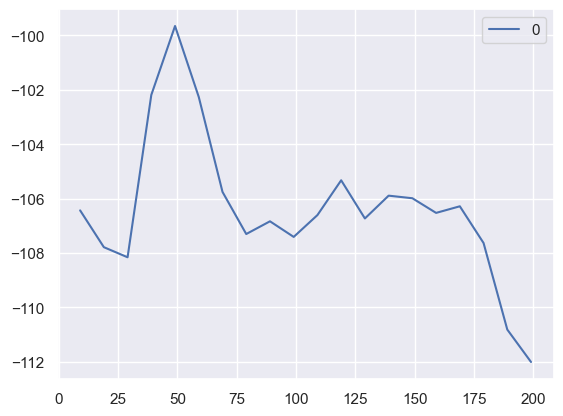

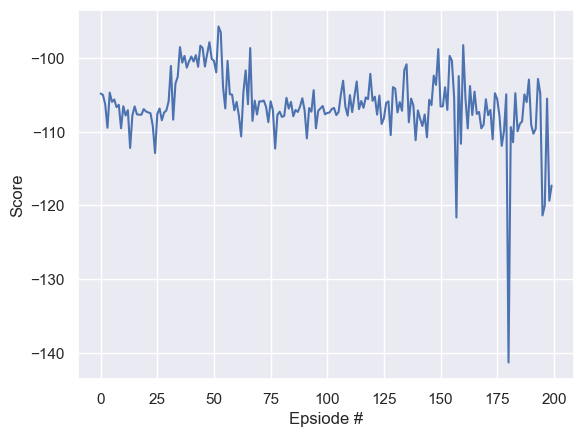

In [8]:
agent = Agent(state_space = env.observation_space, action_space = env.action_space, disc_class = 20, seed = 0)

def train(n_episodes = 200, max_t = 1600):
    """
    Training DQN
    
    @param n_episodes(int): Number of training episodes
    @param max_t(int):      Maximum number of timesteps per episode
    eps_start(float):       Starting value of epsilon for epsilon-greedy action selection
    eps_end(float):         Minimum value of epsilon
    eps_dec(float):         Multiplicative factor for decrementing epsilon
    """
    # For plotting
    scores = [ ]
    scores_window = deque(maxlen=100) 
    for episode in range(1,n_episodes+1):
        print('\rEpisode {}'.format(episode), end="\n")
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        score = 0
        for t in range(max_t):
            action = agent.choose_action(state)
            action = agent.disct2cont(action)
            observation, reward, terminated, truncated, _  = env.step(action)
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            reward = torch.tensor([reward],device = device)
            agent.step(state, action, next_state, reward)
            state = next_state
            done = terminated or truncated
            score += reward[0]
            if done:
                break
        # For plotting
        scores_window.append(score)
        scores.append(score)
        print('\rAverage Score {:.2f}'.format(np.mean(scores_window)), end="\n")
        if score > 300:
            print(f"Environment solved! t:{t}, episode:{episode}")
            break
    return scores

scores = train()
plot_returns(scores)
#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()
                